In [1]:
#import Libraries
import pyspark
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#import pyspark in order to use sql
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql import types as T
from pyspark.sql import Row
from pyspark.sql.window import Window
from pyspark import SparkContext

#import transformers and Berk tokenizer in order to transform twitter text to tokens
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)


#use this module to initialize the sparkContext
#SparkContext.setSystemProperty('spark.executor.memory', '32g')

sc = SparkContext("local", "App Name")
spark = SQLContext(sc)


In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Row
from pyspark.sql.window import Window


conf = pyspark.SparkConf()
conf.setMaster("local").setAppName("test").set("spark.local.dir", "tmp/spark")
SparkContext.setSystemProperty('spark.driver.memory','16g')
SparkContext.setSystemProperty('spark.executor.memory','16g')
sc = pyspark.SparkContext(conf=conf)
#SparkConf conf = new SparkConf().setMaster("local”).setAppName("test”).set("spark.local.dir", "/tmp/spark-temp");

#sc = SparkContext("local", "App Name")
spark = SQLContext(sc)

In [2]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

@F.udf("String")
def decode_tokens(tokens):
  return tokenizer.decode(tokens)

In [4]:
#Initialize the type of the schema that the twitter data have
#Create the fields that characterize the data
fields = list()

fields.append(T.StructField("text_tokens",  T.StringType(), True))
fields.append(T.StructField("hashtags", T.StringType(), True))
fields.append(T.StructField("tweet_id", T.StringType(), True))
fields.append(T.StructField("present_media", T.StringType(), True))
fields.append(T.StructField("present_links", T.StringType(), True))
fields.append(T.StructField("present_domains", T.StringType(), True))
fields.append(T.StructField("tweet_type", T.StringType(), True))
fields.append(T.StructField("language", T.StringType(), True))
fields.append(T.StructField("timestamp", T.LongType(), True))
fields.append(T.StructField("engager_user_id", T.StringType(), True))
fields.append(T.StructField("engager_follower_count", T.LongType(), True))
fields.append(T.StructField("engager_following_count", T.LongType(), True))
fields.append(T.StructField("engager_is_verified", T.BooleanType(), True))
fields.append(T.StructField("engager_account_creation_time", T.LongType(), True))
fields.append(T.StructField("engagee_user_id", T.StringType(), True))
fields.append(T.StructField("engagee_follower_count", T.LongType(), True))
fields.append(T.StructField("engagee_following_count", T.LongType(), True))
fields.append(T.StructField("engagee_is_verified", T.BooleanType(), True))
fields.append(T.StructField("engagee_account_creation_time", T.LongType(), True))
fields.append(T.StructField("engagee_follows_engager", T.BooleanType(), True))
fields.append(T.StructField("reply_engagement_timestamp", T.LongType(), True))
fields.append(T.StructField("retweet_engagement_timestamp", T.LongType(), True))
fields.append(T.StructField("retweet_with_comment_engagement_timestamp", T.LongType(), True))
fields.append(T.StructField("like_engagement_timestamp", T.LongType(), True))

#Create the final schema
schema = T.StructType(fields)

In [6]:
#get the input parts by accessing the file path, probably it will change
training_file_path = "/media/user2/TOSHIBA EXT/code/Twitter_data_30-4-21/part-*"
#create dataframe with the input dataset
training_df = spark.read.option("sep", chr(1)).schema(schema).csv(training_file_path)
#preprocess the data
training_df = training_df.withColumn("text_tokens", F.split("text_tokens", "\t"))
training_df = training_df.withColumn("hashtags", F.split("hashtags", "\t"))
training_df = training_df.withColumn("present_media", F.split("present_media", "\t"))
training_df = training_df.withColumn("present_links", F.split("present_links", "\t"))
training_df = training_df.withColumn("present_domains", F.split("present_domains", "\t"))

In [5]:
#check if the data were accessed
training_df.printSchema()
training_df.show()

root
 |-- text_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tweet_id: string (nullable = true)
 |-- present_media: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- present_links: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- present_domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tweet_type: string (nullable = true)
 |-- language: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- engager_user_id: string (nullable = true)
 |-- engager_follower_count: long (nullable = true)
 |-- engager_following_count: long (nullable = true)
 |-- engager_is_verified: boolean (nullable = true)
 |-- engager_account_creation_time: long (nullable = true)
 |-- engagee_user_id: string (nullable = true)
 |-- engagee_follower_count: long (nullable = true)
 |-- engagee_foll

In [8]:
#get the two parts of validation dataset
validation_file_path = "/media/user2/2.0 TB Hard Disk/validation_set/part-*"
#create dataframe with the validation dataset
validation_df = spark.read.option("sep", chr(1)).schema(schema).csv(validation_file_path)
validation_df = validation_df.withColumn("text_tokens", F.split("text_tokens", "\t"))
validation_df = validation_df.withColumn("hashtags", F.split("hashtags", "\t"))
validation_df = validation_df.withColumn("present_media", F.split("present_media", "\t"))
validation_df = validation_df.withColumn("present_links", F.split("present_links", "\t"))
validation_df = validation_df.withColumn("present_domains", F.split("present_domains", "\t"))

In [10]:
validation_df.count()

28542288

In [12]:
validation_df.shape()

AttributeError: 'DataFrame' object has no attribute 'shape'

In [5]:
#observe the data
# check empty engagements
none_engagements = (F.col("reply_engagement_timestamp").isNull() & F.col("retweet_engagement_timestamp").isNull() & F.col("retweet_with_comment_engagement_timestamp").isNull() & F.col("like_engagement_timestamp").isNull())

#engagee activity in the first 24 hours
engagee_activity = training_df\
.filter(~none_engagements)\
.select(F.col("engagee_user_id"), F.col("reply_engagement_timestamp"), F.col("retweet_engagement_timestamp"), F.col("retweet_with_comment_engagement_timestamp"), F.col("like_engagement_timestamp"))\
.withColumn("like_engagment", F.when(~F.col("like_engagement_timestamp").isNull(), F.array(F.col("like_engagement_timestamp"), F.lit("like"))))\
.withColumn("reply_engagment", F.when(~F.col("reply_engagement_timestamp").isNull(), F.array(F.col("reply_engagement_timestamp"), F.lit("reply"))))\
.withColumn("rt_engagment", F.when(~F.col("retweet_engagement_timestamp").isNull(), F.array(F.col("retweet_engagement_timestamp"), F.lit("retweet"))))\
.withColumn("rtwithcmt_engagment", F.when(~F.col("retweet_with_comment_engagement_timestamp").isNull(), F.array(F.col("retweet_with_comment_engagement_timestamp"), F.lit("rtWithcmt"))))\
.withColumn("engagment", F.array(F.col("like_engagment"), F.col("reply_engagment"), F.col("rt_engagment"), F.col("rtwithcmt_engagment")))\
.drop("reply_engagement_timestamp", "retweet_engagement_timestamp", "retweet_with_comment_engagement_timestamp", "like_engagement_timestamp", "like_engagment", "reply_engagment", "rt_engagment", "rtwithcmt_engagment")\
.select(F.col("engagee_user_id"), F.explode(F.col("engagment")))\
.filter(~F.col("col").isNull())\
.select(F.col("engagee_user_id"), F.col("col")[0].alias("engage_timestamp"), F.col("col")[1].alias("engage_type"))\
.withColumn("time", F.to_timestamp(F.col("engage_timestamp")+0))\
.withColumn("day", F.dayofmonth(F.col("time")))\
.withColumn("hour", F.hour(F.col("time")))\
.withColumn("minute", F.minute(F.col("time")))\
.filter(F.col("day")==6)


#display data
(engagee_activity.groupBy("day", "hour").agg(F.sum(F.when(F.col("engage_type")=="like", 1).otherwise(0)).alias("like"),F.sum(F.when(F.col("engage_type")=="retweet", 1).otherwise(0)).alias("retweet"),F.sum(F.when(F.col("engage_type")=="reply", 1).otherwise(0)).alias("reply"),F.sum(F.when(F.col("engage_type")=="rtWithcmt", 1).otherwise(0)).alias("rtWithCmt"))).show()

+---+----+------+-------+-----+---------+
|day|hour|  like|retweet|reply|rtWithCmt|
+---+----+------+-------+-----+---------+
|  6|  20|529721| 107998|38741|     9261|
|  6|   1|511769|  90560|36939|     8532|
|  6|  22|483205|  86742|35584|     8262|
|  6|  17|636809| 156873|43839|    11197|
|  6|   0|520882|  89902|38853|     8634|
|  6|   8|400494|  98522|24846|     5748|
|  6|   5|483774| 107851|33925|     8158|
|  6|  12|499336| 119836|31612|     7135|
|  6|  13|548275| 133142|34866|     8463|
|  6|  18|601059| 137363|42375|    10928|
|  6|  21|502076|  94664|37084|     8805|
|  6|  15|629292| 151085|41161|    10263|
|  6|  23|494201|  85569|35624|     8265|
|  6|   7|420749| 102307|27155|     6604|
|  6|   3|469974|  95020|34461|     8035|
|  6|   2|478809|  90184|35081|     8261|
|  6|  10|426539| 103147|27238|     5900|
|  6|  14|591084| 144201|38411|     9260|
|  6|  11|457017| 109335|28836|     6458|
|  6|  16|640920| 155022|42637|    10698|
+---+----+------+-------+-----+---

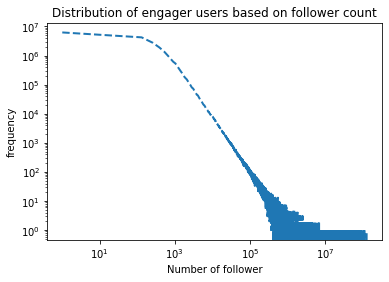

In [7]:
#engager follower distribution
users = training_df.dropDuplicates(["engager_user_id"]).select("engager_user_id", "engager_follower_count", "engager_following_count", "engager_is_verified", "engager_account_creation_time")
bins, counts = users.select("engager_follower_count").rdd.flatMap(lambda x: x).histogram(1000000)
#create plots
fig, ax = plt.subplots()
plt.plot(bins[:-1], counts,'--',label='degrees', linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of follower")
plt.ylabel("frequency")
plt.title("Distribution of engager users based on follower count")
plt.show()

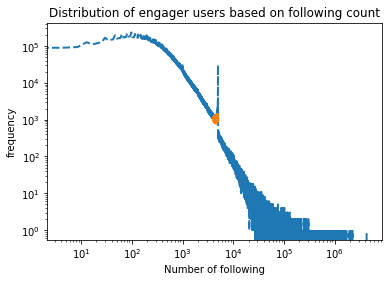

In [8]:
#engager following distribution
users = training_df.dropDuplicates(["engager_user_id"]).select("engager_user_id", "engager_follower_count", "engager_following_count", "engager_is_verified", "engager_account_creation_time")
bins, counts = users.select("engager_following_count").rdd.flatMap(lambda x: x).histogram(1000000)
#create plots
fig, ax = plt.subplots()
plt.plot(bins[:-1], counts,'--',label='degrees', linewidth=2)
plt.plot(bins[1000:1130], counts[1000:1130],'-', linewidth=4)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of following")
plt.ylabel("frequency")
plt.title("Distribution of engager users based on following count")
plt.show()

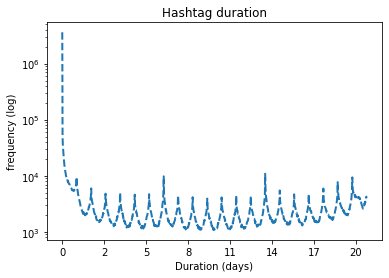

In [9]:
#hashtag duration
import matplotlib.ticker as ticker

tweets = training_df.dropDuplicates(["tweet_id"])

hashtagActivity = tweets\
.filter(~F.col("hashtags").isNull())\
.select(F.explode("hashtags").alias("hashtag"), "timestamp")
bins, counts = hashtagActivity\
.groupby("hashtag").agg(F.min("timestamp").alias("start_timestamp"), (F.max("timestamp") - F.min("timestamp")).alias("duration"), F.count("timestamp").alias("cnt"))\
.select("duration").rdd.flatMap(lambda x: x).histogram(1000)

fig, ax = plt.subplots()
plt.plot(bins[:-1], counts,'--', linewidth=2)
plt.yscale("log")

scale_x = 24*60*60
scale_y = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(int(x/scale_x)))
ax.xaxis.set_major_formatter(ticks_x)

plt.xlabel("Duration (days)")
plt.ylabel("frequency (log)")
plt.title("Hashtag duration")
plt.show()

In [6]:
training_df_writing_parquet = "./parquet_files/training_df.parquet"
#training_df.repartition(1).write.mode('overwrite').parquet(training_df_writing_parquet)
training_df.write.parquet('training_df.parquet')

In [6]:
validation_df_writing_parquet = "parquet_files/validation_df.parquet"
validation_df.write.parquet(validation_df_writing_parquet)

In [ ]:
validation_df.